In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
images = "./flickr/Images"
text = "./flickr/captions.txt"

In [3]:
# Open the file in read mode
with open("./flickr/captions.txt", 'r') as file:
    content = file.read()
c=0
filenames = []
captions = []
for line in content.split('\n'):
    c+=1
    if c == 1 or c == 40457:
        continue
    x = line.split('.jpg')
    filenames.append(x[0]+".jpg")
    captions.append(x[1].lower()[1:])
    # if c == 10: break
    # if len(x) != 2:
    #     print(x)
    #     print(c)

In [4]:
len(captions)

40455

In [5]:
index = list(range(1, len(filenames) + 1))

# Create the DataFrame
df = pd.DataFrame({
    "filename": filenames,
    "index": index,
    "caption": captions
})

In [6]:
df.head()

,filename,index,caption
0,1000268201_693b08cb0e.jpg,1,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,2,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,3,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,4,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,5,a little girl in a pink dress going into a woo...


In [7]:
unique_files = np.unique(df.filename.values)
print(len(unique_files))

8091


In [8]:
# To find captions of an image
cap = df[df['filename'] == "1000268201_693b08cb0e.jpg"]['caption']

print(cap)

0    a child in a pink dress is climbing up a set o...
1                a girl going into a wooden building .
2     a little girl climbing into a wooden playhouse .
3    a little girl climbing the stairs to her playh...
4    a little girl in a pink dress going into a woo...
Name: caption, dtype: object


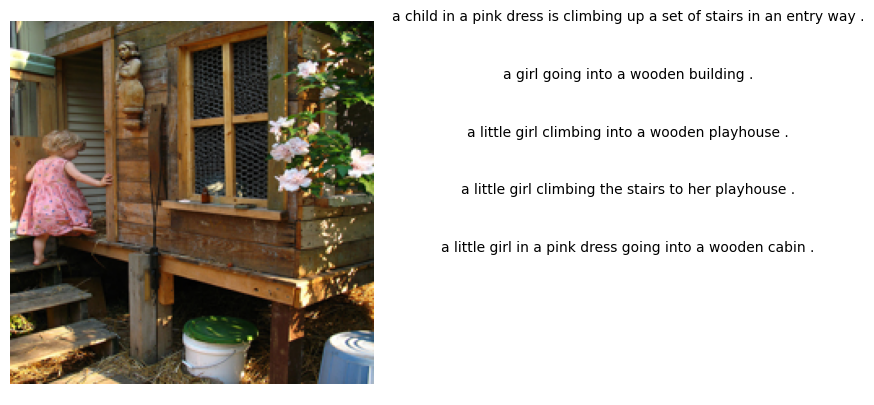

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = './flickr/Images/1000268201_693b08cb0e.jpg'
image = Image.open(image_path).resize((224, 224))

# plt.imshow(image)
# Create a figure with a specified size
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the image in the left subplot
axs[0].imshow(image)
axs[0].axis('off')  # Turn off axis for the image

# Display the captions in the right subplot
axs[1].axis('off')  # Turn off axis for the caption area
for i, caption in enumerate(cap):
    axs[1].text(0.5, 1 - (i * 0.15), caption, ha='center', va='top', fontsize=10)

# Adjust layout to allocate more space to the image
plt.subplots_adjust(left=0.1, right=0.9, wspace=0.2)
plt.show()

In [10]:
# Making a dictionary which contains most frequent wor
def freq(df):
    vocab = []
    c = 0
    for t in df.caption.values:
        vocab.extend(t.split())
    ct = Counter(vocab)
    words = pd.DataFrame({"word":ct.keys(), "count":ct.values()})
    words = words.sort_values(by="count", ascending=False)
    print("Total number of words",len(words))
    return words
words = freq(df)
print(words)

Total number of words 9180
               word  count
0                 a  61752
14                .  34212
2                in  18965
22              the  18249
37               on  10732
...             ...    ...
5765     waterspout      1
5766       perfomed      1
5768        closeby      1
5770  competitively      1
9179       patterns      1

[9180 rows x 2 columns]


In [11]:
# Removing punctuation, single characters and numeric characters
import re
pattern = r'[^\w\s]|\b\w\b|\d'

# Sample string
text = "Hello! This is a sample text, with numbers 123 and single chars like a, b, and punctuations!!!"

# Remove punctuations, single characters, and numbers
cleaned_text = re.sub(pattern, '', text)
cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
print(cleaned_text)

Hello This is sample text with numbers and single chars like and punctuations


In [12]:
def cleaning_text(text):
    return re.sub(r'\s+', ' ', re.sub(pattern, '', text))
    
for i, caption in enumerate(df.caption.values):
    newcaption = cleaning_text(caption).strip()
    df.loc[i, "caption"] = newcaption

In [13]:
df.head(5)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,1,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,2,girl going into wooden building
2,1000268201_693b08cb0e.jpg,3,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,4,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,5,little girl in pink dress going into wooden cabin


In [14]:
words = freq(df)
print(words)

Total number of words 8759
           word  count
1            in  18974
20          the  18418
35           on  10743
4            is   9345
26          and   8851
...         ...    ...
5863       tune      1
2059      razer      1
5865  haystacks      1
5867  trackside      1
8758   patterns      1

[8759 rows x 2 columns]


In [15]:
# Adding start and end sequences
def add_start_end_tokens(caption):
    return "startseq " + caption + " endseq"

df["caption"] = df["caption"].apply(add_start_end_tokens)

In [16]:
import torch
import torchvision.models as models
import torch.nn as nn

vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])
vgg16 = vgg16.to('cuda')
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
vgg16(torch.randn(2,3,224,224).to('cuda'))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<NativeDropoutBackward0>)

In [19]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
print(torch.version.cuda)

True
12.4


In [20]:
import os
all_images = os.listdir("./flickr/Images")
print(len(all_images))

8091


In [55]:
# from keras.preprocessing.image import load_img, img_to_array
# from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
import os
from torchvision import transforms
images = OrderedDict()
npix = 224
target_size = (npix,npix)
# data = np.zeros((len(jpgs),npix,npix,3))
preprocess = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
]
)

c = 0
all_images = os.listdir("./flickr/Images")
for i,name in enumerate(all_images):
    c += 1
    # print(name)
    # load an image from file
    filename = './flickr/Images/' + name
    image = Image.open(filename)
    image = preprocess(image)
    # print(image)
    image = image.unsqueeze(0) # To add batch dimension
    image = image.to('cuda')
    with torch.no_grad():
        y_pred = vgg16(image)
    images[name] = y_pred
    # print(f"name: {name}, y_pred: {y_pred}")
    # print(f"Updated images: {images}")
    # 8091 total images
    if c % 100 == 0: print("Image",c,"processed")
    # if c == 300: break

Image 100 processed
Image 200 processed
Image 300 processed
Image 400 processed
Image 500 processed
Image 600 processed
Image 700 processed
Image 800 processed
Image 900 processed
Image 1000 processed
Image 1100 processed
Image 1200 processed
Image 1300 processed
Image 1400 processed
Image 1500 processed
Image 1600 processed
Image 1700 processed
Image 1800 processed
Image 1900 processed
Image 2000 processed
Image 2100 processed
Image 2200 processed
Image 2300 processed
Image 2400 processed
Image 2500 processed
Image 2600 processed
Image 2700 processed
Image 2800 processed
Image 2900 processed
Image 3000 processed
Image 3100 processed
Image 3200 processed
Image 3300 processed
Image 3400 processed
Image 3500 processed
Image 3600 processed
Image 3700 processed
Image 3800 processed
Image 3900 processed
Image 4000 processed
Image 4100 processed
Image 4200 processed
Image 4300 processed
Image 4400 processed
Image 4500 processed
Image 4600 processed
Image 4700 processed
Image 4800 processed
I

In [49]:
len(images)

8091

In [45]:
# Using PCA to visualise the 4096 dimensional space in 2 dimensions

from sklearn.decomposition import PCA

# encoder = np.array()

In [46]:
# DO visualisation of PCA space later



In [53]:
# Removing captions and images that do not have corresponding images/captions

keptimages, keepindex = [],[]

for index, filename in enumerate(df.filename):
    # print(index)
    if filename in all_images:
        keptimages.append(images[filename])
        keepindex.append(index)

filenames = df["filename"].iloc[keepindex].values
captions = df["caption"].iloc[keepindex].values
keptimages = [image.cpu().numpy() for image in keptimages]
# keptimages = np.array(keptimages)

In [62]:
len(keepindex)

40455

In [61]:
from transformers import AutoTokenizer
from collections import Counter

# Initialize tokenizer for a specific model, e.g., BERT's tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the captions using the tokenizer
tokenized_captions = [tokenizer.tokenize(caption) for caption in df["caption"]]

# Count the frequency of words
counter = Counter([word for caption in tokenized_captions for word in caption])

# Limit vocabulary to num_words most common words
num_words = 8000
vocab = counter.most_common(num_words)

# Create a word-to-index mapping
word_index = {word: idx + 1 for idx, (word, _) in enumerate(vocab)}

# Add 1 to the vocabulary size to account for special tokens
vocab_size = len(word_index) + 1
print("vocabulary size : {}".format(vocab_size))

# Convert texts to sequences
captions = [[word_index[word] for word in caption if word in word_index] for caption in tokenized_captions]
print(captions[:5])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/home/aditya/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


vocabulary size : 7449
[[4, 1, 2, 45, 5, 95, 179, 8, 128, 54, 421, 13, 429, 5, 29, 5277, 767, 3, 1, 2], [4, 1, 2, 20, 343, 67, 204, 127, 3, 1, 2], [4, 1, 2, 43, 20, 128, 67, 204, 2697, 3, 1, 2], [4, 1, 2, 43, 20, 128, 6, 429, 21, 63, 2697, 3, 1, 2], [4, 1, 2, 43, 20, 5, 95, 179, 343, 67, 204, 3267, 3, 1, 2]]


In [73]:
# Train and test data split

length = len(captions)
test_num = 0.2 * length
val_num = 0.2 * length

def split(data, test_num, val_num):
    return(data[:test_num], data[test_num:test_num+val_num], data[test_num+val_num:])
test_num = int(test_num)
val_num = int(val_num)
caption_test, caption_val, caption_train = split(captions, test_num, val_num)
image_test, image_val, image_train = split(keptimages, test_num, val_num)
fname_test, fname_val, fname_train = split(filenames, test_num, val_num)

In [79]:
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

def preprocessing(captions,images):
    N = len(captions)
    print("# captions/images = {}".format(N))

    assert(N==len(images))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(captions,keptimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequence([torch.tensor(in_text)],batch_first=True,padding_value=0)
            in_text = in_text.flatten()[-maxlen:]
            out_text = F.one_hot(torch.tensor(out_text), num_classes=vocab_size).float()
            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = torch.stack(Xtext)
    Ximage = torch.stack(Ximage)
    ytext  = torch.stack(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(caption_train,image_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(caption_val,image_val)

# captions/images = 24273


NameError: name 'maxlen' is not defined

In [ ]:
from torch
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ImageCaptionModel(nn.Module):
    def __init__(self, vocab_size, dim_embedding, maxlen):
        super(ImageCaptionModel, self).__init__()

        # Image feature extraction
        self.image_feature = nn.Linear(256, 256)  # Assuming Ximage_train.shape[1] = 256

        # Text embedding and LSTM
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.lstm = nn.LSTM(dim_embedding, 256, batch_first=True)

        # Combined decoder
        self.decoder_fc1 = nn.Linear(256, 256)  # Output of combined image and text features
        self.decoder_fc2 = nn.Linear(256, vocab_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image, caption):
        # Image feature pathway
        image_features = self.image_feature(image)
        image_features = self.relu(image_features)

        # Text feature pathway
        embedded_captions = self.embedding(caption)  # [batch_size, maxlen, dim_embedding]
        _, (hidden_state, _) = self.lstm(embedded_captions)  # LSTM returns hidden states
        text_features = hidden_state.squeeze(0)  # Extract the final hidden state

        # Combine the two feature sets (image and text)
        combined_features = image_features + text_features

        # Decoder layers
        decoder_output = self.decoder_fc1(combined_features)
        decoder_output = self.relu(decoder_output)
        output = self.decoder_fc2(decoder_output)

        return self.softmax(output)

# Model Initialization
vocab_size = 8000
dim_embedding = 64
maxlen = 100  # Assuming the maximum length of text

model = ImageCaptionModel(vocab_size, dim_embedding, maxlen)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Summary (show the architecture)
print(model)
